# Hyper Parameters

In [177]:
import torch
import torch.nn as nn
from torch.nn import functional as F


# hyperparameters
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 4000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 6
dropout = 0.2

score_size=3
# ------------
feel_count=16
feel_embd=32
# ------------


torch.manual_seed(1337)

# Data loading

In [178]:
from google.colab import drive
import pandas as pd

#drive.mount('/content/drive')
#with open("/content/drive/MyDrive/LLm fighthing/karamazov.txt", "r", encoding="utf-8") as f:
#  text=f.read()

!wget "https://raw.githubusercontent.com/BlastOfMihh/TennisMania/refs/heads/model/tt%20csv%20artificial.CSV"
one_csv_path="./tt csv artificial.CSV"

df=pd.read_csv(one_csv_path)
df = df.drop(df.columns[0], axis=1)
df

hb_column = df.iloc[:, 0]
min_hb = hb_column.min()
max_hb = hb_column.max()
diff_hb = max_hb - min_hb + 1
print(min_hb, max_hb, max_hb-min_hb)




--2025-01-17 00:05:11--  https://raw.githubusercontent.com/BlastOfMihh/TennisMania/refs/heads/model/tt%20csv%20artificial.CSV
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3554 (3.5K) [text/plain]
Saving to: ‘tt csv artificial.CSV.21’

tt csv artificial.C 100%[===================>]   3.47K  --.-KB/s    in 0s      

2025-01-17 00:05:11 (47.8 MB/s) - ‘tt csv artificial.CSV.21’ saved [3554/3554]

75 124 49


In [179]:
first_column = df.iloc[:, 0]

#Creating the dataset, Encoder, Decoder


In [180]:
# here are all the unique characters that occur in this text
#chars = sorted(list(set(text)))
# chars=[]
# heart_beat_min = df.iloc[:, 0].min()
# heart_beat_max = df.iloc[:, 0].max()
# for hb in range(heart_beat_min, heart_beat_max):
#   for p1 in range(0,12):
#     for p1 in range(0,12):
#       chars.append()
#
# def encode_(hb, p1, p2):
#   return hb*1000+p2*100+p1
#
#
# for i in range(60)
#
# vocab_size = len(chars)
# # create a mapping from characters to integers
# stoi = { ch:i for i,ch in enumerate(chars) }
# itos = { i:ch for i,ch in enumerate(chars) }
# encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
#data = torch.tensor(encode(text), dtype=torch.long)





csv_tensor=torch.tensor(df.values)


data = torch.stack([csv_tensor]*100, dim=0).to(device)

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def pick_block(x):
  start=torch.randint(0, len(x)-block_size+1 -1, (1,))
  return x[start:start+block_size-1],  x[start+1:start+block_size-1+1]

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data

    ix = torch.randint(0, len(data), (batch_size,))

    data_blocks=[pick_block(data[i]) for i in ix]
    x=torch.stack([block[0] for block in data_blocks], dim=0).to(device)
    y=torch.stack([block[1] for block in data_blocks], dim=0).to(device)

    return x, y

get_batch('train')[0].shape



torch.Size([4, 7, 3])

# F Model


In [181]:
# The feel stuff
class FeelHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.key = nn.Linear(feel_embd, head_size, bias=False)

        self.value = nn.Linear(feel_embd, head_size, bias=False)

        self.feelings = torch.rand(feel_count, feel_embd).to(device)

        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        q = self.query(x) # (B,T,C)

        k = self.key(self.feelings) # (f_cnt, C)
        k = k.expand(B, -1,-1) # (B, F_cnt, C)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, F_cnt) -> (B, T, F_cnt)
        #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, )
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(self.feelings) # (f_cnt, C)
        v = v.expand(B,-1,-1) # (B, F_cnt, C)
        out = wei @ v # (B, T, F_cnt) @ (B, F_cnt, C) -> (B, T, C)
        return out


class MultiHeadFeeling(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([FeelHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# Model Regular

In [182]:
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, model_type):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)

        self.ffwd = FeedFoward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

        self.model_type=model_type
        if model_type=='feel':
          self.mh_feel=MultiHeadFeeling(n_head, head_size)
          self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        if self.model_type=='feel':
          x = x + self.mh_feel(self.ln3(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, model_type):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Linear(score_size, n_embd) # changed this
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head, model_type=model_type) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, diff_hb+12+12)

    def forward(self, idx, targets=None):
        B, T, _= idx.shape
        idx=idx.to(torch.float32)
        # idx and targets are both (B,T,3) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,3)

        if targets is None:
            loss = None

            logits_hb = logits[:, :, :diff_hb]
            logits_p1 = logits[:, :, diff_hb:diff_hb+12]
            logits_p2 = logits[:, :, diff_hb+12:diff_hb+12+12]
        else:
            B, T, C = logits.shape

            logits_hb = logits[:, :, :diff_hb].view(B*T, diff_hb)
            logits_p1 = logits[:, :, diff_hb:diff_hb+12].view(B*T, 12)
            logits_p2 = logits[:, :, diff_hb+12:diff_hb+12+12].view(B*T, 12)

            targets_hb = targets[:, :, 0:1].view(B*T)
            targets_p1 = targets[:, :, 1:2].view(B*T)
            targets_p2 = targets[:, :, 2:3].view(B*T)

            loss_hb = F.cross_entropy(logits_hb, targets_hb-torch.full((B*T,),min_hb))
            loss_p1 = F.cross_entropy(logits_p1, targets_p1)
            loss_p2 = F.cross_entropy(logits_p2, targets_p2)

            loss = loss_hb + loss_p1 + loss_p2


#            logits = logits.view(B*T, C)
#            targets = targets.view(B*T)

            #loss =  F.mse_loss(logits, targets) # changed this ?
            #loss = F.cross_entropy(logits, targets)
        return (logits_hb, logits_p1, logits_p2), loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            (logits_hb, logits_p1, logits_p2), loss = self(idx_cond)
            # focus only on the last time step
            logits_hb = logits_hb[:, -1, :] # becomes (B, C)
            logits_p1 = logits_p1[:, -1, :] # becomes (B, C)
            logits_p2 = logits_p2[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs_hb = F.softmax(logits_hb, dim=-1) # (B, C)
            probs_p1 = F.softmax(logits_p1, dim=-1) # (B, C)
            probs_p2 = F.softmax(logits_p2, dim=-1) # (B, C)
            # sample from the distribution
            hb_next = torch.multinomial(probs_hb, num_samples=1) # (B, 1)
            p1_next = torch.multinomial(probs_p1, num_samples=1) # (B, 1)
            p2_next = torch.multinomial(probs_p2, num_samples=1) # (B, 1)

            idx_next = torch.stack([hb_next,p1_next,p2_next], dim=-1)
            # breakpoint()
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model_sdf = BigramLanguageModel('regular').to(device)

idx=torch.stack([torch.stack([torch.tensor([85.0, 0.0, 0.0])]).to(device)])
model_sdf.generate(idx, 10)

#m = model.to(device)
# print the number of parameters in the model
#print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')



tensor([[[85.,  0.,  0.],
         [38.,  9.,  1.],
         [ 9.,  3., 11.],
         [ 0.,  0.,  1.],
         [23.,  4.,  0.],
         [35.,  9., 10.],
         [26., 11.,  6.],
         [26.,  5.,  4.],
         [48., 10.,  4.],
         [19.,  8.,  4.],
         [ 9., 11.,  6.]]])

#Training and loss estimation functions


In [183]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# create a PyTorch optimizer
def get_optimizer(model):
  return torch.optim.AdamW(model.parameters(), lr=learning_rate)

def train_model(model, optimizer, history):
  for iter in range(max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss(model)
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
          history['train'].append(losses['train'])
          history['val'].append(losses['val'])

      # sample a batch of data
      xb, yb = get_batch('train')

      # evaluate the loss
      _, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

def generate_from_model(m):
  # generate from the model
  context = torch.zeros((1, 1), dtype=torch.long, device=device)
  print((m.generate(context, max_new_tokens=2000)[0].tolist()))


#Plotting and comparisions

In [184]:
history_regular={
  'train':[],
  'val':[]
}
history_feel={
  'train':[],
  'val':[]
}

In [185]:
model_regular = BigramLanguageModel('regular').to(device)
model_feel = BigramLanguageModel('feel').to(device)

In [186]:
optimizer_regular=get_optimizer(model_regular)
#optimizer_feel=get_optimizer(model_feel)

In [193]:
#train_model(model_feel, optimizer_feel, history_feel)
train_model(model_regular, optimizer_regular, history_regular)

step 0: train loss 3.0020, val loss 2.9880
step 100: train loss 3.0299, val loss 2.9994
step 200: train loss 2.9985, val loss 3.0082
step 300: train loss 2.9813, val loss 2.9939
step 400: train loss 2.9253, val loss 2.9441


KeyboardInterrupt: 

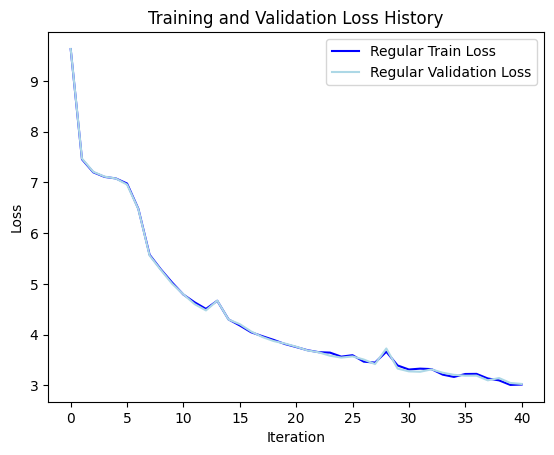

In [188]:
import matplotlib.pyplot as plt

plt.plot(history_regular['train'], label='Regular Train Loss', color='blue')
plt.plot(history_regular['val'], label='Regular Validation Loss', color='lightblue')

#plt.plot(history_feel['train'], label='Feel Train Loss', color='red')
#plt.plot(history_feel['val'], label='Feel Validation Loss', color='salmon')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

In [192]:

context=torch.stack([torch.stack([torch.tensor([85.0, 0.0, 0.0])]).to(device)])
generated_sequence = model_regular.generate(context, max_new_tokens=20)[0].tolist()
generated_sequence



[[85.0, 0.0, 0.0],
 [5.0, 0.0, 0.0],
 [8.0, 1.0, 0.0],
 [8.0, 2.0, 0.0],
 [12.0, 2.0, 0.0],
 [2.0, 1.0, 0.0],
 [7.0, 2.0, 0.0],
 [7.0, 2.0, 0.0],
 [14.0, 1.0, 0.0],
 [9.0, 5.0, 0.0],
 [3.0, 1.0, 0.0],
 [11.0, 1.0, 0.0],
 [14.0, 8.0, 4.0],
 [33.0, 9.0, 4.0],
 [33.0, 10.0, 4.0],
 [35.0, 10.0, 4.0],
 [16.0, 10.0, 4.0],
 [35.0, 10.0, 4.0],
 [4.0, 8.0, 4.0],
 [33.0, 10.0, 4.0],
 [33.0, 10.0, 4.0]]

In [ ]:
import pickle

# Assuming 'model_regular' is your trained model
with open('model_regular.pkl', 'wb') as f:
    pickle.dump(model_regular, f)

In [ ]:
sth=torch.stack([
        torch.tensor([85, 11, 12 ]),
        torch.tensor([95, 21, 22 ]) ,
        torch.tensor([105, 31, 32])
        ]
                 ).to(device)

sth.shape

one=sth[:, 0:1]
two=sth[:, 1:2]
three=sth[:, 2:3]

torch.cat([one,two, three], dim=-1)